In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
from fastai.vision import *
from fastai.callbacks import *
from ranger import Ranger # Lookahead + RAdam

from CinemaNet.MixMatch import *
from CinemaNet.train_utils import to_film_ar
from CinemaNet.wandb import *
from CinemaNet.blend import *
from CinemaNet.convert import *
from CinemaNet.custom_head import *

import wandb

In [4]:
model_name='MNetV2-100x177-3000L-MixMatch'

In [5]:
wandb.init(name    = re.sub('-3000L', '', model_name),
           project = 'Shot Framing -- Supervised (3000L)',
           entity  = 'synopsis')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


W&B Run: https://app.wandb.ai/synopsis/Shot+Framing+--+Supervised+%283000L%29/runs/5497apk0

In [6]:
%env WANDB_NOTEBOOK_NAME='cat_shot-framing_MixMatch.ipynb'

env: WANDB_NOTEBOOK_NAME='cat_shot-framing_MixMatch.ipynb'


## Dataset

In [7]:
path = Path('/home/rahul/github_projects/CinemaNet/')

def get_labels(f):
    if re.search(f"{regex['EWS']}", str(f)): return 'shot_framing_extremewide'
    if re.search(f"{regex['LS']}",  str(f)): return 'shot_framing_long'
    if re.search(f"{regex['MS']}",  str(f)): return 'shot_framing_medium'
    if re.search(f"{regex['MCU']}", str(f)): return 'shot_framing_mediumclose'
    if re.search(f"{regex['CU']}",  str(f)): return 'shot_framing_close'
    if re.search(f"{regex['ECU']}", str(f)): return 'shot_framing_extremeclose'

In [8]:
il_train = ImageList.from_folder(path/'train', presort=True)
il_valid = ImageList.from_folder(path/'valid', presort=True)
regex = {
    'CU' : '\/Close\-Up\/',
    'ECU': '\/Extreme Close\-Up\/',
    'EWS': '\/Extreme Wide\/',
    'LS' : '\/Long\/',
    'MS' : '\/Medium\/',
    'MCU': '\/Medium Close\-Up\/'
}

In [9]:
len(il_train.items)
len(il_valid.items)

5505

600

In [10]:
fnames_all   = list(il_train.items) + list(il_valid.items)
count        = {}
train_fnames = {}
samples_per_label = 500


for key in regex:
    i=0
    train_fnames[key] = []
    for f in fnames_all:
        if re.search(f"{regex[key]}.*", str(f)):
            i+=1
            count[key] = i
            train_fnames[key].append(f)
            if i >= samples_per_label: break; 
count

{'CU': 500, 'ECU': 500, 'EWS': 500, 'LS': 500, 'MS': 500, 'MCU': 500}

In [11]:
fnames_train = sum(train_fnames.values(),[])
fnames_valid = list(set(fnames_all) - set(fnames_train))

In [12]:
len(fnames_train), len(fnames_valid)

(3000, 3105)

In [13]:
lls = LabelLists(path,
                 train=ImageList(fnames_train),
                 valid=ImageList(fnames_valid))

In [14]:
img_size   = to_film_ar(100)
batch_size = 32

In [15]:
def get_data_3000L(img_size, tfms=get_transforms(max_zoom=1.), batch_size=64):
    data = (lls
            .label_from_func(get_labels)
            .transform(tfms=get_transforms(max_zoom=1.),
                       size=img_size,
                       resize_method=ResizeMethod.SQUISH)
            .databunch(bs=batch_size).normalize(imagenet_stats))
    return data

In [16]:
data = get_data_3000L(img_size)
data

ImageDataBunch;

Train: LabelList (3000 items)
x: ImageList
Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177)
y: CategoryList
shot_framing_close,shot_framing_close,shot_framing_close,shot_framing_close,shot_framing_close
Path: .;

Valid: LabelList (3105 items)
x: ImageList
Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177)
y: CategoryList
shot_framing_medium,shot_framing_close,shot_framing_medium,shot_framing_close,shot_framing_extremeclose
Path: .;

Test: None

For the unlabelled data, grab 5000 images per class. 5000 * 6 = 30000

In [17]:
ul_per_class = 5000
ul_total = 5000 * data.c

ul_list = ImageList.from_folder(path/'filmgrab', presort=True)

np.random.seed(1234)
np.random.shuffle(ul_list.items)
ul_list = ul_list[:ul_total]

len(ul_list)
ul_list

30000

ImageList (30000 items)
Image (3, 544, 1280),Image (3, 694, 1280),Image (3, 688, 1280),Image (3, 720, 958),Image (3, 552, 1024)
Path: /home/rahul/github_projects/CinemaNet/filmgrab

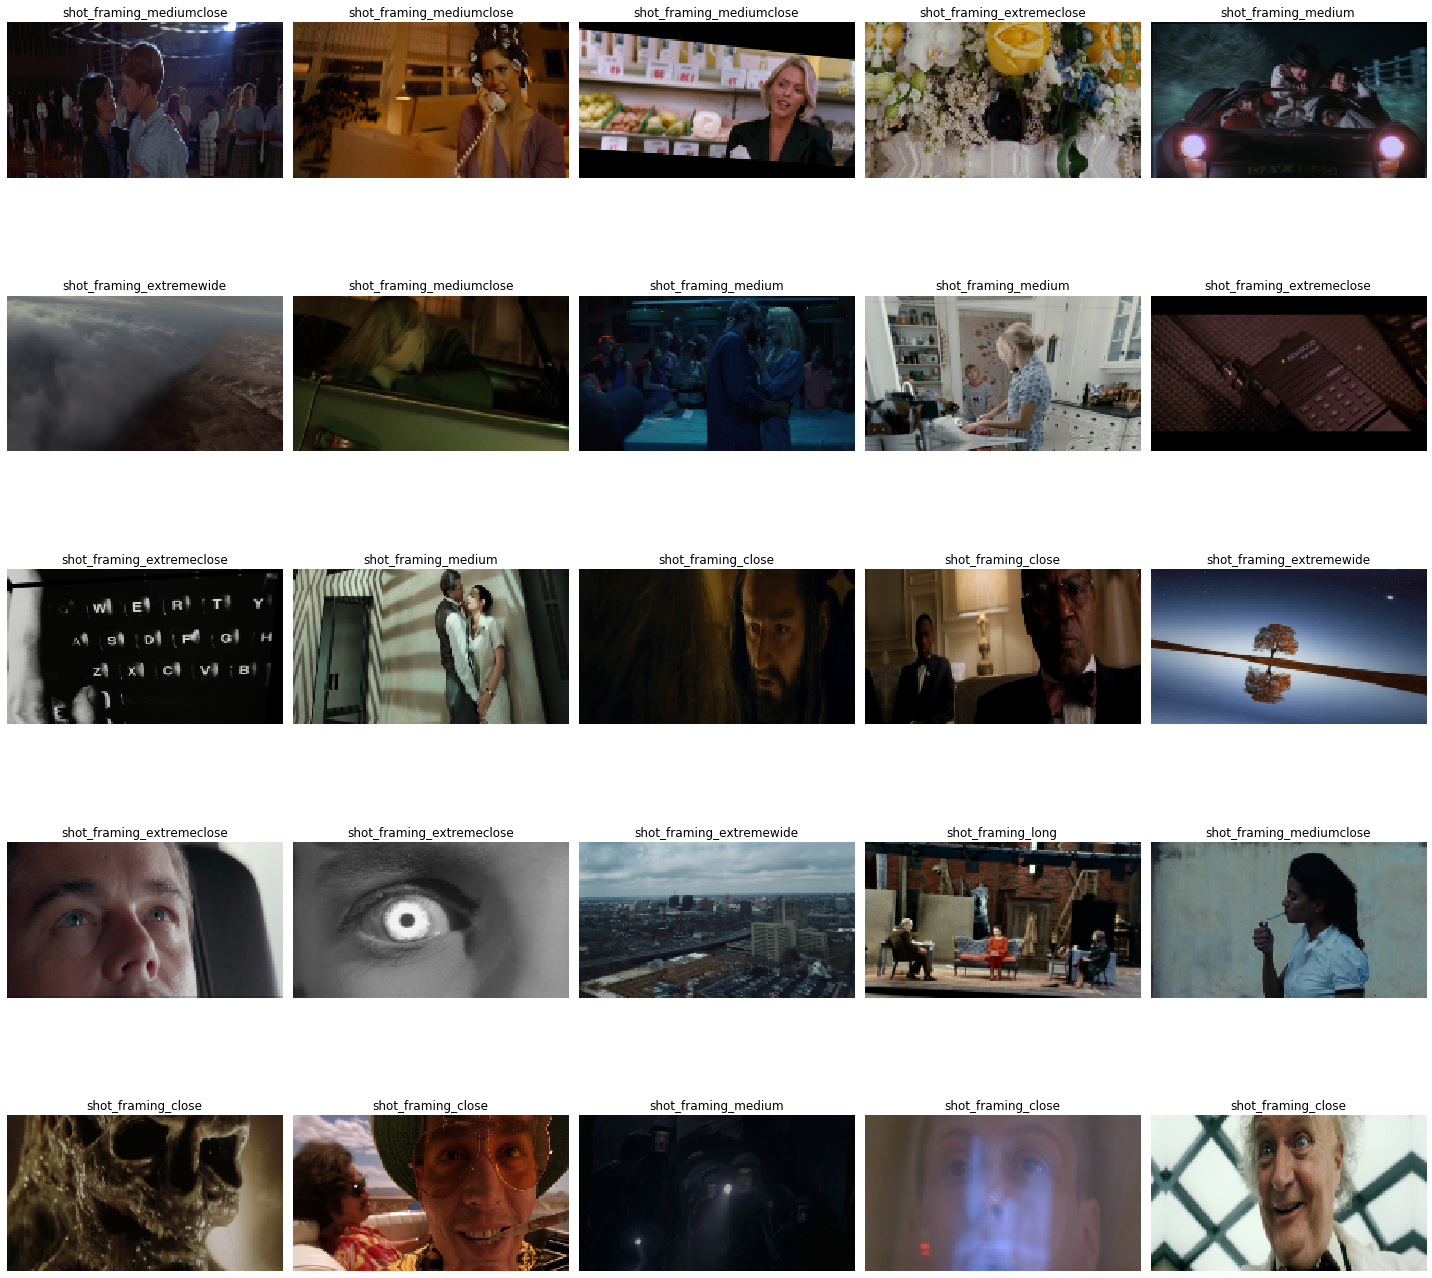

In [21]:
data.show_batch()

## MixMatch Training

In [18]:
opt_func  = Ranger
loss_func = LabelSmoothingCrossEntropy()
arch      = models.mobilenet_v2

In [19]:
metrics = [accuracy, FBeta()]

def get_callbacks(learner, mod_name, monitor='accuracy'):
    return [
        SaveModelCallback(learner, every='epoch', name=mod_name, monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images',
                          log='all', predictions=100)
    ]

In [20]:
learn = cnn_learner(data, arch, metrics=metrics,
                    #opt_func=opt_func,  # Ranger seems to hang MixMatch training, use Adam (default)
                    loss_func=loss_func,
                    bn_wd=False)

In [21]:
model_name
callbacks = get_callbacks(learn, model_name)
learn.save(model_name) # `SaveModelCallback` sometimes tries to load model before saving it. Odd.

'MNetV2-100x177-3000L-MixMatch'

In [22]:
learn = learn.mixmatch(ul_list, size=img_size, α=.75, λ=75)
learn.unfreeze()

In [23]:
learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False),
 functools.partial(<class 'CinemaNet.MixMatch.MixMatchCallback'>, labeled_data=ImageDataBunch;
 
 Train: LabelList (3000 items)
 x: ImageList
 Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177)
 y: CategoryList
 shot_framing_close,shot_framing_close,shot_framing_close,shot_framing_close,shot_framing_close
 Path: .;
 
 Valid: LabelList (3105 items)
 x: ImageList
 Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177),Image (3, 100, 177)
 y: CategoryList
 shot_framing_medium,shot_framing_close,shot_framing_medium,shot_framing_close,shot_framing_extremeclose
 Path: .;
 
 Test: None, T=0.5, K=2, α=0.75, λ=75)]

In [24]:
torch.cuda.empty_cache()

labeled dataset     :         3,000 samples
unlabeled dataset   :        30,000 samples
total train samples :        89,856 samples


epoch,train_loss,valid_loss,accuracy,f_beta,train_Lx,train_Lu*λ,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 1.20E-02


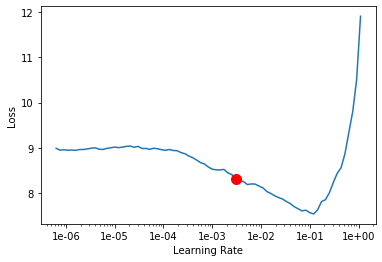

In [25]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [26]:
torch.cuda.empty_cache()

In [27]:
learn = learn.mixmatch(ul_list, size=img_size, α=.75, λ=75)
learn.unfreeze()

In [28]:
learn.fit_fc(100, 3e-3, wd=1e-2, callbacks=callbacks)

labeled dataset     :         3,000 samples
unlabeled dataset   :        30,000 samples
total train samples :     8,985,600 samples


epoch,train_loss,valid_loss,accuracy,f_beta,train_Lx,train_Lu*λ,time
0,3.340906,2.528729,0.201932,0.093087,2.415612,0.925290,16:59


/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with accuracy value: 0.2019323706626892.
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200127_150928-5497apk0/bestmodel.pth


KeyboardInterrupt: 